In [1]:
import pandas as pd
import torch
from transformers import (
    DPRQuestionEncoder, DPRQuestionEncoderTokenizer,
    DPRContextEncoder, DPRContextEncoderTokenizer
)

/home/zuber_purahoo2/datascience-venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PHASE 1 - DATASET LOADING

A 30K sample in the format of (query,positive passage,negative passage) is retrieved from the original dataset 'triples.train.small.tsv'

In [2]:
####### DO NOT USE THIS DATASET ########
####### USE: qidpidtriples.top3.clean.tsv ########
file_path = r"qidpidtriples.top3.clean.tsv"

df = pd.read_csv(
    file_path,
    sep='\t',
    header=None,
    names=["query", "positive", "negative"],
    encoding='utf-16',         
)
df.shape

(29999, 3)

PHASE 2 - TRAIN-TEST SPLIT

Split into train set (80%) and test set (20%)

In [3]:

# Convert to Hugging Face Dataset
from datasets import Dataset
train_dataset = Dataset.from_pandas(df)

print(train_dataset[0])


{'query': 'another name for the primary visual cortex is', 'positive': 'the primary (parts of the cortex that receive sensory inputs from the thalamus) visual cortex is also known as v1, v isual area one, and the striate cortex.the extrastriate areas consist of visual areas two (v2), three (v3), four (v4), and five (v5).he primary visual cortex is the best-studied visual area in the brain. in all mammals studied, it is located in the posterior pole of the occipital cortex (the occipital cortex is responsible for processing visual stimuli).', 'negative': 'the frontal lobe of the brain. the frontal lobe is concerned with executing behavior. this ranges from the control of individual muscles in the primary motor cortex to high level abstract planning about what to do.hese lobes are further divided into different regions. the frontal lobes are involved with control of movement, from stimulation of individual muscles to abstract planning about what to do. the parietal lobe processes visual,

PHASE 3: TRAINING STAGE

1. The first step is to load the question and context encoders of the DPR model

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
# Question encoder
question_encoder = DPRQuestionEncoder.from_pretrained("facebook/dpr-question_encoder-single-nq-base").to(DEVICE)
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained("facebook/dpr-question_encoder-single-nq-base")

# Context encoder
context_encoder = DPRContextEncoder.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base").to(DEVICE)
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")

cuda


Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the

2. Creation of the dataset class

In [5]:
class DPRDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.data = hf_dataset
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data[idx]  
        return {
            "query": row["query"],
            "positive_passage": row["positive"],
            "negative_passage": row["negative"]
        }

train_dpr_dataset = DPRDataset(train_dataset)

print(len(train_dpr_dataset))
print(train_dpr_dataset[0])

29999
{'query': 'another name for the primary visual cortex is', 'positive_passage': 'the primary (parts of the cortex that receive sensory inputs from the thalamus) visual cortex is also known as v1, v isual area one, and the striate cortex.the extrastriate areas consist of visual areas two (v2), three (v3), four (v4), and five (v5).he primary visual cortex is the best-studied visual area in the brain. in all mammals studied, it is located in the posterior pole of the occipital cortex (the occipital cortex is responsible for processing visual stimuli).', 'negative_passage': 'the frontal lobe of the brain. the frontal lobe is concerned with executing behavior. this ranges from the control of individual muscles in the primary motor cortex to high level abstract planning about what to do.hese lobes are further divided into different regions. the frontal lobes are involved with control of movement, from stimulation of individual muscles to abstract planning about what to do. the parietal 

3. Definition of the collate_fn() function

In [6]:
import torch
from torch.utils.data import DataLoader

# Hyperparameters
BATCH_SIZE  = 16
Q_MAX_LEN   = 64
CTX_MAX_LEN = 256

# Collate function for batching and tokenization
def collate_fn(batch):
    queries   = [b["query"] for b in batch]
    positives = [b["positive_passage"] for b in batch]
    negatives = [b["negative_passage"] for b in batch]

    # Tokenize queries
    q_enc = question_tokenizer(
        queries, padding=True, truncation=True, max_length=Q_MAX_LEN,
        pad_to_multiple_of=8, return_tensors="pt"
    )

    # Tokenize passages (positives + negatives)
    ctx_enc = context_tokenizer(
        positives + negatives, padding=True, truncation=True, max_length=CTX_MAX_LEN,
        pad_to_multiple_of=8, return_tensors="pt"
    )

    return q_enc, ctx_enc

train_dpr_dataset = DPRDataset(train_dataset)

train_loader = DataLoader(
    train_dpr_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)


Training loop

/tmp/ipykernel_1813/837769827.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=torch.cuda.is_available())
/tmp/ipykernel_1813/837769827.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


Epoch 1/3  Loss: 0.0464
Epoch 2/3  Loss: 0.0192
Epoch 3/3  Loss: 0.0093


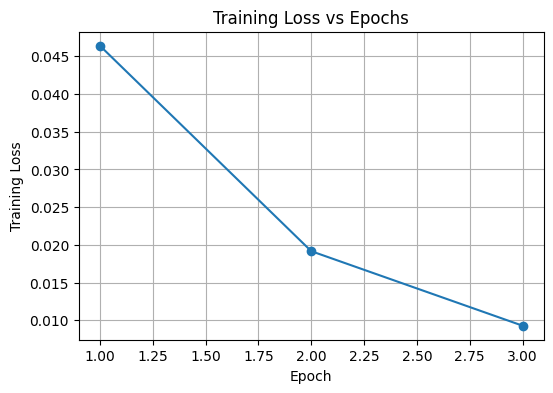

In [7]:
import torch
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt

EPOCHS = 3
LEARNING_RATE = 5e-6

optimizer = torch.optim.AdamW(list(question_encoder.parameters()) + list(context_encoder.parameters()),
                              lr=LEARNING_RATE)

scaler = GradScaler(enabled=torch.cuda.is_available())
epoch_losses = []

question_encoder.train()
context_encoder.train()

for epoch in range(EPOCHS):
    total_loss = 0.0

    for q_enc, ctx_enc in train_loader:
        optimizer.zero_grad()

        # -------Move batch to GPU
        q_enc   = {k: v.to(DEVICE, non_blocking=True) for k,v in q_enc.items()}
        ctx_enc = {k: v.to(DEVICE, non_blocking=True) for k,v in ctx_enc.items()}

        B = q_enc["input_ids"].size(0)

        # -------Forward pass with mixed precision
        with autocast(enabled=torch.cuda.is_available()):
            q_out   = question_encoder(**q_enc).pooler_output  # [B, H]
            ctx_out = context_encoder(**ctx_enc).pooler_output  # [2B, H]
            p_out, n_out = ctx_out.split(B, dim=0)

            # -------Cosine margin loss
            pos = torch.cosine_similarity(q_out, p_out, dim=1)
            neg = torch.cosine_similarity(q_out, n_out, dim=1)
            loss = (0.2 - pos + neg).clamp_min_(0).mean()

        # -------Backward + optimizer step
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}  Loss: {avg_loss:.4f}")

plt.figure(figsize=(6,4))
plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.grid(True)
plt.show()

Model saving

In [8]:
question_encoder.save_pretrained("./dpr_question_encoder")
context_encoder.save_pretrained("./dpr_context_encoder")
question_tokenizer.save_pretrained("./dpr_question_encoder")
context_tokenizer.save_pretrained("./dpr_context_encoder")

print("Training complete and models saved!")

Training complete and models saved!


Collect all passages for FAISS

In [14]:
import pandas as pd

# -------Load collection
collection = pd.read_csv("common_dataset.tsv", sep="\t", names=["pid", "text"], dtype={"pid": str, "text": str})


print(len(collection))  # -------smaller than full 8.8M

30000


In [ ]:
import torch
from tqdm import tqdm
from datasets import Dataset
from torch.utils.data import DataLoader
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

context_encoder.eval()
context_encoder.to(DEVICE)

# ----------------------------------------------
# Multi-process pre-tokenization with HuggingFace Datasets
# ----------------------------------------------
# Create a HF Dataset containing only the passage text column
raw_ds = Dataset.from_pandas(collection[["text"]])

# Tokenization function (returns dict of model inputs)
def tok(batch):
    return context_tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",   # fixed length => tensorize easily
        max_length=256,
    )

# Map with multiprocessing (adjust num_proc to available CPU cores)
# remove original text column to save memory
print("Tokenizing passages (multi-process)...")
tok_ds = raw_ds.map(
    tok,
    batched=True,
    batch_size=512,
    num_proc=4,          # change if you have fewer cores
    remove_columns=["text"],
    desc="Tokenizing"
)

# Set PyTorch format for direct tensor access
Tok_COLUMNS = [c for c in ["input_ids", "attention_mask", "token_type_ids"] if c in tok_ds.column_names]
tok_ds.set_format(type="torch", columns=Tok_COLUMNS)

# DataLoader to stream batches to the encoder (no need for workers now; already tokenized)
EMB_BATCH_SIZE = 64  # tune based on GPU memory
passage_loader = DataLoader(tok_ds, batch_size=EMB_BATCH_SIZE, shuffle=False)

passage_embeddings = []
print("Encoding passages...")
with torch.no_grad():
    for batch in tqdm(passage_loader, desc="Encoding"):
        batch = {k: v.to(DEVICE, non_blocking=True) for k, v in batch.items()}
        emb = context_encoder(**batch).pooler_output  # [B, H]
        passage_embeddings.append(emb.cpu())

# Concatenate all batches
passage_embeddings = torch.cat(passage_embeddings, dim=0).numpy()
print("Passage embeddings shape:", passage_embeddings.shape)

# Save
np.save("passage_embeddings.npy", passage_embeddings)

Tokenizing passages (multi-process)...


Setting TOKENIZERS_PARALLELISM=false for forked processes.
Tokenizing (num_proc=4):   0%|          | 0/30000 [00:00<?, ? examples/s]

Tokenizing (num_proc=4): 100%|██████████| 30000/30000 [00:17<00:00, 1742.69 examples/s]



Encoding passages...


Encoding: 100%|██████████| 469/469 [07:02<00:00,  1.11it/s]

Passage embeddings shape: (30000, 768)


Save embeddings

In [11]:
import numpy as np

# Load later
passage_embeddings = np.load("passage_embeddings.npy")
print(passage_embeddings.shape)

(30000, 768)


Build FAISS Index

In [12]:
import faiss
dim = passage_embeddings.shape[1]  # typically 768 for DPR
faiss.normalize_L2(passage_embeddings)  # normalize for cosine similarity
index = faiss.IndexFlatIP(dim)
index.add(passage_embeddings)

print("Number of vectors in FAISS:", index.ntotal)

Number of vectors in FAISS: 30000


METRICS

In [16]:
import math
import numpy as np
import torch
import faiss
from tqdm import tqdm
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer
import pandas as pd
from eval_metrics import average_precision_at_k, ndcg_at_k, recall_at_k

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# ----------------------------
# Load DPR + FAISS + collection
# ----------------------------
question_encoder = DPRQuestionEncoder.from_pretrained("./dpr_question_encoder").to(DEVICE)
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained("./dpr_question_encoder")

# NOTE: passage_embeddings rows must align with collection rows (same order)
passage_embeddings = np.load("passage_embeddings.npy").astype("float32")
index = faiss.IndexFlatIP(passage_embeddings.shape[1])
index.add(passage_embeddings)

# 'collection' must have ['pid','text'] aligned to embeddings
# e.g., collection = pd.read_csv(...); ensure pid is str
collection["pid"] = collection["pid"].astype(str)
pids_list = collection["pid"].tolist()
pid_set = set(pids_list)

# ----------------------------
# Evaluation
# ----------------------------
def evaluate(queries_df: pd.DataFrame,
             qrels_df: pd.DataFrame,
             top_k=10,
             recall_k=100,
             batch_size=32):
    """
    queries_df: DataFrame with columns ['qid','query'] (types as str)
    qrels_df  : DataFrame with columns ['qid','pid','rel'] (pid, qid as str; rel int)
    """

    # Build relevance maps per query
    # rel_dict_by_qid: qid -> {pid: rel}  (supports graded relevance)
    # rel_set_by_qid : qid -> {pid, ...}  (binary set for AP/Recall)
    rel_dict_by_qid = {}
    rel_set_by_qid = {}
    for qid, group in qrels_df.groupby("qid"):
        d = {pid: int(rel) for pid, rel in zip(group["pid"], group["rel"])}
        rel_dict_by_qid[qid] = d
        rel_set_by_qid[qid]  = {pid for pid, r in d.items() if r > 0}

    # Map qid -> query text
    qid2query = dict(zip(queries_df["qid"], queries_df["query"]))
    qids = list(qid2query.keys())
    queries_list = [qid2query[q] for q in qids]

    prec_scores, ap_scores, ndcg_scores, recall_scores = [], [], [], []

    # We’ll retrieve max(top_k, recall_k)
    search_k = max(top_k, recall_k)

    for start in tqdm(range(0, len(queries_list), batch_size), desc="Evaluating"):
        batch_qids = qids[start:start + batch_size]
        batch_queries = queries_list[start:start + batch_size]

        enc = question_tokenizer(
            batch_queries,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=64
        ).to(DEVICE)

        with torch.no_grad():
            q_emb = question_encoder(**enc).pooler_output          # [B, dim]
            q_emb = torch.nn.functional.normalize(q_emb, p=2, dim=1)

        D, I = index.search(q_emb.detach().cpu().numpy(), search_k)  # [B, search_k]

        for b, qid in enumerate(batch_qids):
            ranked_pids = [pids_list[idx] for idx in I[b]]
            rel_dict = rel_dict_by_qid[qid]
            rel_set  = rel_set_by_qid[qid]

            # Precision@k (binary)
            hits_topk = sum(1 for pid in ranked_pids[:top_k] if pid in rel_set)
            prec_scores.append(hits_topk / top_k)

            # MAP@k (binary set)
            ap_scores.append(average_precision_at_k(ranked_pids, rel_set, k=top_k))

            # nDCG@k (graded rel via rel_dict; binary also works)
            ndcg_scores.append(ndcg_at_k(ranked_pids, rel_dict, k=top_k))

            # Recall@100 (binary)
            recall_scores.append(recall_at_k(ranked_pids, rel_set, k=recall_k))

    return {
        f"Precision@{top_k}": float(np.mean(prec_scores)) if prec_scores else 0.0,
        f"MAP@{top_k}": float(np.mean(ap_scores)) if ap_scores else 0.0,
        f"nDCG@{top_k}": float(np.mean(ndcg_scores)) if ndcg_scores else 0.0,
        f"Recall@{recall_k}": float(np.mean(recall_scores)) if recall_scores else 0.0,
        "num_queries": len(queries_list)
    }

# ----------------------------
# Run evaluation (same inputs as before, but PID-based)
# ----------------------------
queries = pd.read_csv("queries.dev.tsv", sep="\t", names=["qid", "query"],
                      dtype={"qid": str, "query": str})
qrels   = pd.read_csv("qrels.dev.tsv", sep="\t", names=["qid","_","pid","rel"],
                      dtype={"qid": str, "pid": str, "rel": int})

# Keep only qrels whose pid exists in our (possibly sampled) collection
qrels_for_eval = qrels[qrels["pid"].isin(collection["pid"])][["qid","pid","rel"]].copy()

# Use the subset of queries that appear in these qrels
queries_eval = queries[queries["qid"].isin(qrels_for_eval["qid"])][["qid","query"]].drop_duplicates("qid")

# (Optional) sample queries for speed
sampled_queries = queries_eval.sample(n=min(1000, len(queries_eval)), random_state=42)

metrics = evaluate(sampled_queries, qrels_for_eval, top_k=10, recall_k=10, batch_size=32)
print(metrics)


Evaluating: 100%|██████████| 32/32 [00:03<00:00,  8.71it/s]

{'Precision@10': 0.07479999999999999, 'MAP@10': 0.5216283730158731, 'nDCG@10': 0.5713189568053693, 'Recall@10': 0.7225, 'num_queries': 1000}
